In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [162]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [4]:
desc = pd.read_pickle('desc_clean.pickle')

In [19]:
vocab = set()
for k,v in desc.items():
    for caption in v:
        for w in caption.split():
            vocab.add(w)

In [23]:
print('word count :' , len(vocab))

word count : 8885


### Create description with startseq_endseq

In [27]:
work_desc = {}
for k,v in desc.items():
    
    if k not in work_desc:
        work_desc[k] = []
            
    for caption in v:
        caption = f'startseq {caption} endseq'
        work_desc[k].append(caption)

In [31]:
work_desc[k]

['startseq man in pink shirt climbs rock face endseq',
 'startseq man is rock climbing high in the air endseq',
 'startseq person in red shirt climbing up rock face covered in assist handles endseq',
 'startseq rock climber in red shirt endseq',
 'startseq rock climber practices on rock climbing wall endseq']

### Load feature set

In [32]:
features = pd.read_pickle('feature_set.pickle')

In [50]:
len(features) # number of images

8091

### encoding text -- assigns number to each word

In [218]:
from itertools import chain

def to_lines(descriptions):
    return list(chain(*descriptions))

def create_tokenizer(descriptions):
    
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return tokenizer

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max([len(d.split()) for d in lines])

In [219]:
tokenizer = create_tokenizer(work_desc.values())

In [220]:
vocab_size = len(tokenizer.word_index)+1
print(f'vacab size : {vocab_size}')

vacab size : 8485


In [221]:
max_length = max_length(work_desc.values())

In [238]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key.split('.')[0]][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

In [ ]:
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, work_desc, features, vocab_size)

In [224]:
X1train

array([], dtype=float64)

In [214]:
def define_model(vocab_size,max_length):
    # feature extraction model
    input1 = Input(shape=(4096,))
    fc1     = Dropout(0.5)(input1)
    fc2     = Dense(units=256,activation='relu')(fc1)
    
    # sequence model
    input2 = Input(shape=(max_length))
    se1    = Embedding(vocab_size,256,mask_zero=True)(input2)
    se2    = Dropout(0.5)(se1)
    se3    = LSTM(256)(se2)
    
    # decoder model
    decoder1 = add([fc2,se3])
    decoder2 = Dense(units = 256 ,activation='relu')(decoder1)
    output   = Dense(units=vocab_size , activation='softmax')(decoder2)
    
    # tie it all together
    
    model = Model(inputs=[input1 , input2] , outputs=output)
    
    return model

In [215]:
model = define_model(vocab_size,max_length)

In [216]:
model.compile(optimizer='adam',loss='categorical_crossentropy')

In [ ]:
model.fit([X1train, X2train], ytrain,epochs=10,verbose=2)

### Caption generation

In [5]:
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

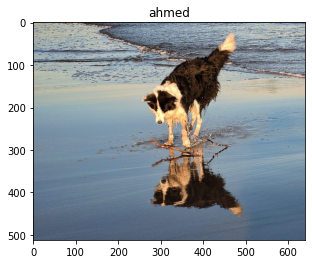

startseq dog is running across the beach endseq


In [9]:
img = plt.imread('dog.jpg')
plt.imshow(img)
plt.show()

generate_desc(model,tokenizer,img,max_length)